# Training8

In this notebook file, Between80And90-FullPhoto dataset will be read from pkl file.

Input(X) and Output(Y) numpy arrays will be created from pandas dataframes.

MobileNetV2 pre-trained model will be load and used.

The pre-trained model will be set to non-trainable and will only be used for feature extraction.

Training will only be performed on the output layer, that will be added to the end of the pre-trained model.

In this way, the experience gained by the model on very large data sets will be used for this classification problem.

This method is known as [**Transfer Learning**](https://en.wikipedia.org/wiki/Transfer_learning "wikipedia").

A keras utils Sequence class will be defined so that operations can be performed on the data to be used during the training.

Performance will be checked with Validation data while training model with Augmented Training data.

Accuracy and Loss charts will be drawn according to epoch numbers.

The results obtained by evaluating the model with Test data will be printed.

In [1]:
#Libraries are being imported
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt

In [2]:
#Library versions are being printed
print('numpy Version: ' + np.__version__)
print('pandas Version: ' + pd.__version__)
print('tensorflow Version: ' + tf.__version__)
print('matplotlib Version: ' + matplotlib.__version__)

numpy Version: 1.22.3
pandas Version: 1.4.3
tensorflow Version: 2.6.0
matplotlib Version: 3.5.2


In [3]:
#GPU will be used for training
myGPU = tf.test.gpu_device_name()
if myGPU:
    print(myGPU)
else:
    print("Error")

/device:GPU:0


In [4]:
#Person dataframe in Between80And90 is being read from pkl file
personDf = pd.read_pickle("../../../Data/Between80And90/Person.pkl")
personDf

,Name
ID,
0,Abdullah Gul
1,Amelie Mauresmo
2,Angelina Jolie
3,Bill Gates
4,Carlos Menem
5,Carlos Moya
6,Fidel Castro
7,George Robertson
8,Halle Berry


In [5]:
#FullPhoto Training data is being read from pkl file
trainingDf = pd.read_pickle("../../../Data/Between80And90/FullPhoto/Training.pkl")
trainingDf

,PersonID,ImageBGR
0,28,"[[[0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], ..."
1,13,"[[[2, 1, 0], [2, 0, 0], [0, 0, 0], [0, 0, 1], ..."
2,29,"[[[2, 2, 8], [2, 2, 8], [2, 2, 8], [2, 2, 7], ..."
3,1,"[[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], ..."
4,16,"[[[5, 0, 3], [5, 0, 3], [4, 0, 3], [4, 0, 3], ..."
...,...,...
524,17,"[[[239, 245, 244], [241, 246, 245], [243, 249,..."
525,30,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
526,13,"[[[12, 19, 58], [14, 19, 58], [14, 19, 58], [1..."
527,23,"[[[9, 68, 87], [3, 59, 83], [6, 55, 89], [9, 5..."


In [6]:
#trainingX is being extracted from trainingDf as wanted shape
#trainingX contains images with pixel values of data type np.uint8 in the range [0, 255]

#Since the pre-trained model to be used in this notebook, MobileNetV2, trained with RGB color ordered images by default,
#all images are being converted from BGR color order to RGB color order.
#[:, :, :, ::-1] code swaps the first and last channels of each image in a numpy array containing 3 channel images
#This way all images can be converted from BGR color order to RGB color order in one line

#Many pre-trained models, including the ones to be used within the scope of this project,
#have been trained with images containing pixel values in the [-1, 1] range
#In this way, the data will be symmetrical and the performance of the Backpropagation algorithm will be increased
#See https://en.wikipedia.org/wiki/Backpropagation
#See also https://stackoverflow.com/questions/59540276/why-in-preprocessing-image-data-we-need-to-do-zero-centered-data
#Therefore, training will be performed by converting pixel values to this range with the simplest method (pixel / 127.5 - 1)

#Data augmentation, can also be done in Data Preparation process or this section to save time
#But this method is not preferred due to memory problems

trainingX = (np.array(trainingDf.ImageBGR.values.tolist())[:, :, :, ::-1] / 127.5) - 1
trainingX.shape

(529, 224, 224, 3)

In [7]:
#trainingY is being extracted from trainingDf as wanted shape
trainingY = np.array(trainingDf.PersonID.values.tolist()).reshape((-1,1))
trainingY.shape

(529, 1)

In [8]:
#FullPhoto Validation data is being read from pkl file
validationDf = pd.read_pickle("../../../Data/Between80And90/FullPhoto/Validation.pkl")
validationDf

,PersonID,ImageBGR
0,36,"[[[84, 37, 15], [83, 36, 14], [83, 36, 14], [8..."
1,27,"[[[0, 3, 4], [0, 3, 4], [0, 2, 5], [0, 1, 5], ..."
2,22,"[[[35, 94, 109], [36, 96, 110], [37, 97, 113],..."
3,33,"[[[241, 246, 245], [241, 246, 245], [239, 244,..."
4,26,"[[[73, 95, 130], [77, 100, 134], [78, 103, 137..."
...,...,...
116,8,"[[[108, 42, 7], [109, 43, 8], [110, 44, 9], [1..."
117,29,"[[[1, 1, 1], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
118,5,"[[[20, 15, 30], [18, 13, 28], [17, 12, 27], [1..."
119,2,"[[[244, 246, 234], [245, 247, 235], [245, 247,..."


In [9]:
#validationX is being extracted from validationDf as wanted shape
#validationX contains images with pixel values of data type np.uint8 in the range [0, 255]

#Since the pre-trained model to be used in this notebook, MobileNetV2, trained with RGB color ordered images by default,
#all images are being converted from BGR color order to RGB color order.
#[:, :, :, ::-1] code swaps the first and last channels of each image in a numpy array containing 3 channel images
#This way all images can be converted from BGR color order to RGB color order in one line

#Many pre-trained models, including the ones to be used within the scope of this project,
#have been trained with images containing pixel values in the [-1, 1] range
#In this way, the data will be symmetrical and the performance of the Backpropagation algorithm will be increased
#See https://en.wikipedia.org/wiki/Backpropagation
#See also https://stackoverflow.com/questions/59540276/why-in-preprocessing-image-data-we-need-to-do-zero-centered-data
#Therefore, training will be performed by converting pixel values to this range with the simplest method (pixel / 127.5 - 1)

validationX = (np.array(validationDf.ImageBGR.values.tolist())[:, :, :, ::-1] / 127.5) - 1
validationX.shape

(121, 224, 224, 3)

In [10]:
#validationY is being extracted from validationDf as wanted shape
validationY = np.array(validationDf.PersonID.values.tolist()).reshape((-1,1))
validationY.shape

(121, 1)

In [11]:
#MobileNetV2 pre-trained model is being loaded
#The original MobileNetV2 model was trained with images with size of (224, 224, 3) 
#in RGB color order and pixel values of [-1, 1] (zero centered) as default
#See https://keras.io/api/applications/mobilenet/ for more information
#Since images of dataset saved as size of (224, 224, 3) in BGR color order and pixel values of [0, 255]
#Color orders were changed from BGR to RGB and pixel values were converted to [-1, 1] range
#while preparing trainingX and validationX

#Model is set to non-trainable
#In this way, the convolutional layers that will be used for feature extraction will be used without changing them
#Output layer will be fed the feature-map obtained from the pre-trained convolutional model
#the training process will be performed on this layer

model = tf.keras.applications.MobileNetV2(include_top = False, weights = 'imagenet', input_shape = ((224, 224, 3)))
model.trainable = False
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [12]:
#The pre-trained model is being connected to the Average Pooling layer
#A dropout layer is added to the the model to prevent overfitting,
#and the model is completed with the addition of the output layer
model = tf.keras.models.Sequential([
    model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(personDf.shape[0], activation = tf.nn.softmax)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 40)                51240     
Total params: 2,309,224
Trainable params: 51,240
Non-trainable params: 2,257,984
_________________________________________________________________


In [13]:
#Model is being compiled with Adam optimizer
#Adam optimizer is a common used optimizer
#See https://keras.io/api/optimizers/adam/
#See also https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e
#SparseCategoricalCrossentropy loss function is being used because of the label format of the data
#SparseCategoricalAccuracy is being used as metric because of the label format of the data
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name = 'accuracy')]
)

In [14]:
#A class inherited from keras utils Sequence is being created
class FitSequence(tf.keras.utils.Sequence):
    
    #Constructor method is being defined
    def __init__(self, image, label, batchSize, imagesPerImage):
        self.image, self.label = image, label
        self.batchSize = batchSize
        
        #A numpy array for image indexes is being created
        #This array will be used to shuffle the data
        self.index = np.arange(self.image.shape[0])
        self.imagesPerImage = imagesPerImage
        
        #batch sizes are being calculated for correct information during training
        self.originalBatch = self.image.shape[0] / float(self.batchSize)
        self.batchLen = int(np.ceil(self.originalBatch * self.imagesPerImage))
        self.originalBatch = int(np.ceil(self.originalBatch))
        self.repeatData = -1
        
        #Image Augmentation layer
        #See https://www.tensorflow.org/tutorials/images/data_augmentation
        self.imageAugmentation = tf.keras.Sequential([
          tf.keras.layers.RandomFlip("horizontal_and_vertical"),
          tf.keras.layers.RandomRotation(0.2),
        ])
        

    #__len__ method is being defined
    #This method will be used by the model to show the amount of progress of each epoch
    def __len__(self):
        return self.batchLen

    #__getitem__ method is being defined
    #The model will retrieve the batches it will use during training by calling this method
    #With this method, the data to be used by the model can be manipulated
    def __getitem__(self, idx):
        
        #Since randomly augmented images obtained from the same image will be added to the batches,
        #there will be more batches than expected
        #so the taken index is updated by taking the mode according to the original batch
        idx = idx % self.originalBatch
        
        #If the index is 0, that is, the loop in the epoch has returned to the beginning
        if idx == 0:
            
            #The index array is being shuffled
            #so that the data in the next repeat is returned in different orders
            np.random.shuffle(self.index)
            
            #repeatData is being incremented by 1
            self.repeatData += 1
            
        #When the model requests data, the next batch size will be selected based on index array
        indexPart = self.index[idx * self.batchSize : (idx + 1) * self.batchSize]
        
        #if it is the first iteration of data in the epoch,
        #selected data from data in original list are being returned
        if self.repeatData == 0:
            return self.__OriginalBatch(indexPart)
        
        #if it is not the first iteration of data in the epoch,
        #data augmented using select data are being returned
        else:
            return self.__AugmentedBatch(indexPart)
        
    #on_epoch_end method is being defined
    #The model will call this method after each epoch is ended
    def on_epoch_end(self):
        
        #repeatData is updated to -1 at the end of each epoch
        self.repeatData = -1
    
    #this method will be called if element from original list will be returned
    def __OriginalBatch(self, indexPart):
        
        batchX = self.image[indexPart]
        batchY = self.label[indexPart]
        return np.array(batchX), np.array(batchY)
    
    #This method will be called if images created with the data augmentation method will be returned
    #Doing Data Augmentation operation here means that it will be repeated as many epochs for each image and this wastes time
    #On the other hand, since the data augmentation process is done with random rotation and random flip,
    #different variations can be obtained of the original image each time
    #This can be have a preventative effect on overfitting
    def __AugmentedBatch(self, indexPart):
        augmentedList = []
        for i in indexPart:
            augmentedList.append(self.imageAugmentation(self.image[i]))
        
        batchX = np.array(augmentedList)
        batchY = self.label[indexPart]
        return np.array(batchX), np.array(batchY)

In [15]:
#model is being trained with 50 epochs and 64 batchSize using GPU

#3 more images will be obtained from each original for training data so the number of images will be quadrupled
#Only the originals of the validation data will be used

with tf.device(myGPU):
    trainingHistory = model.fit(
        FitSequence(trainingX, trainingY, 64, 4),
        epochs = 50,
        validation_data = FitSequence(validationX, validationY, 64, 1)
    )

Epoch 1/50
34/34 [==============================] - 57s 1s/step - loss: 3.5038 - accuracy: 0.1165 - val_loss: 3.1961 - val_accuracy: 0.1322
Epoch 2/50
34/34 [==============================] - 42s 1s/step - loss: 2.5212 - accuracy: 0.3435 - val_loss: 2.5900 - val_accuracy: 0.2727
Epoch 3/50
34/34 [==============================] - 37s 1s/step - loss: 1.9338 - accuracy: 0.5012 - val_loss: 2.4065 - val_accuracy: 0.3719
Epoch 4/50
34/34 [==============================] - 39s 1s/step - loss: 1.6206 - accuracy: 0.5887 - val_loss: 2.2014 - val_accuracy: 0.4215
Epoch 5/50
34/34 [==============================] - 40s 1s/step - loss: 1.3765 - accuracy: 0.6698 - val_loss: 2.0702 - val_accuracy: 0.4545
Epoch 6/50
34/34 [==============================] - 43s 1s/step - loss: 1.1898 - accuracy: 0.7184 - val_loss: 2.0043 - val_accuracy: 0.4380
Epoch 7/50
34/34 [==============================] - 33s 970ms/step - loss: 1.0410 - accuracy: 0.7651 - val_loss: 1.9156 - val_accuracy: 0.5124
Epoch 8/50
34/34 

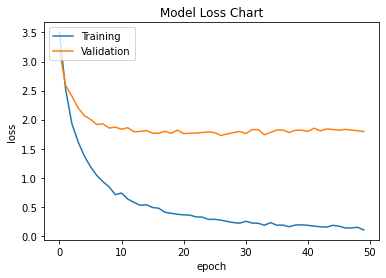

In [16]:
#Loss Chart is being drawn

#Chart Values
plt.plot(trainingHistory.history['loss'])
plt.plot(trainingHistory.history['val_loss'])

#Chart Tittle
plt.title('Model Loss Chart')

#Chart Labels
plt.ylabel('loss')
plt.xlabel('epoch')

#Chart Lines
plt.legend(['Training', 'Validation'], loc='upper left')

#Show Method
plt.show()

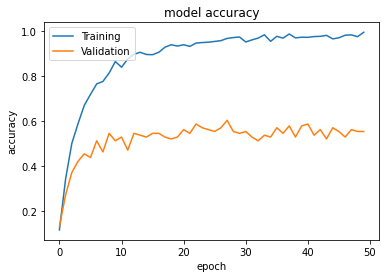

In [17]:
#Loss Chart is being drawn

#Chart Values
plt.plot(trainingHistory.history['accuracy'])
plt.plot(trainingHistory.history['val_accuracy'])

#Chart Tittle
plt.title('model accuracy')

#Chart Labels
plt.ylabel('accuracy')
plt.xlabel('epoch')

#Chart Lines
plt.legend(['Training', 'Validation'], loc='upper left')

#Show Method
plt.show()

In [18]:
#FullPhoto Test data is being read from pkl file
testDf = pd.read_pickle("../../../Data/Between80And90/FullPhoto/Test.pkl")
testDf

,PersonID,ImageBGR
0,1,"[[[100, 142, 119], [100, 142, 119], [100, 142,..."
1,13,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,1,"[[[0, 0, 3], [0, 0, 2], [0, 0, 1], [1, 0, 1], ..."
3,9,"[[[99, 128, 137], [99, 128, 137], [99, 128, 13..."
4,20,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
...,...,...
115,34,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
116,31,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
117,11,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
118,14,"[[[2, 0, 1], [2, 0, 1], [2, 0, 1], [2, 0, 1], ..."


In [19]:
#testX is being extracted from testDf as wanted shape

#Since the pre-trained model to be used in this notebook, MobileNetV2, trained with RGB color ordered images by default,
#all images are being converted from BGR color order to RGB color order.
#[:, :, :, ::-1] code swaps the first and last channels of each image in a numpy array containing 3 channel images
#This way all images can be converted from BGR color order to RGB color order in one line

#Pixel values are being converted  to the [-1, 1] range with the simplest method (pixel / 127.5 - 1)

testX = (np.array(testDf.ImageBGR.values.tolist())[:, :, :, ::-1] / 127.5) - 1
testX.shape

(120, 224, 224, 3)

In [20]:
#testY is being extracted from testDf as wanted shape
testY = np.array(testDf.PersonID.values.tolist()).reshape((-1,1))
testY.shape

(120, 1)

In [21]:
#Model is being evaluated with test data
#Sequence class is being also used for evaluation to convert test data into the same format as training data
testResult = model.evaluate(FitSequence(testX, testY, 64, 1))

2/2 [==============================] - 6s 4s/step - loss: 2.4266 - accuracy: 0.4083


In [22]:
#Test Loss is being Printed
print('Test Loss: ' + str(testResult[0]))

Test Loss: 2.426555871963501


In [23]:
#Test Accuracy is being Printed
print('Test Accuracy: ' + str(testResult[1]))

Test Accuracy: 0.40833333134651184


# Training8 Inference

By looking at the charts, it can be said that training results in overfitting.

A similar architecture was trained with same data in the Training4 notebook file without the Transfer Learning method.

Although the results are much better than those in the Training4 notebook file, a success of about 60% on the Validation data and over 95% on the Training data indicates overfitting.

In this case, it can be said that overfitting is caused by too few images for each person.

This example clearly demonstrates the power of Transfer Learning.

Performance can be improved by trying Hyperparameter Optimization methods.

See https://en.wikipedia.org/wiki/Hyperparameter_optimization.